In [1]:
# general packages
import numpy as np
import os
import sys
import inspect

# H-FISTA packages
currentdir = %pwd 
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from lib import Residual
from fista import fista
from helpers import get_data
from lambda_loop import take_lambda_step, initialize_io_dict, get_initial_lambda
from stopping import check_stopping

# plotting tools
import matplotlib.pyplot as plt
from plotting import make_plots, get_diag_plot, get_paper_figure, get_dynamic_field_plot
from scipy.fft import fftshift

%matplotlib inline

# plot style adjustement, remove if jupyter themes not avaiable
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, ticks=True, grid=False,)

# further plot configuration
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.aspect"] = "auto"
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams["axes.linewidth"] = 3

### Load and plot data

2022-10-27 13:08:49,252 - H-FISTA.helpers - WARNING - Loading data/observed/J1939+2134.fits as a psrflux ASCII file failed. Trying to load as a FITS file.


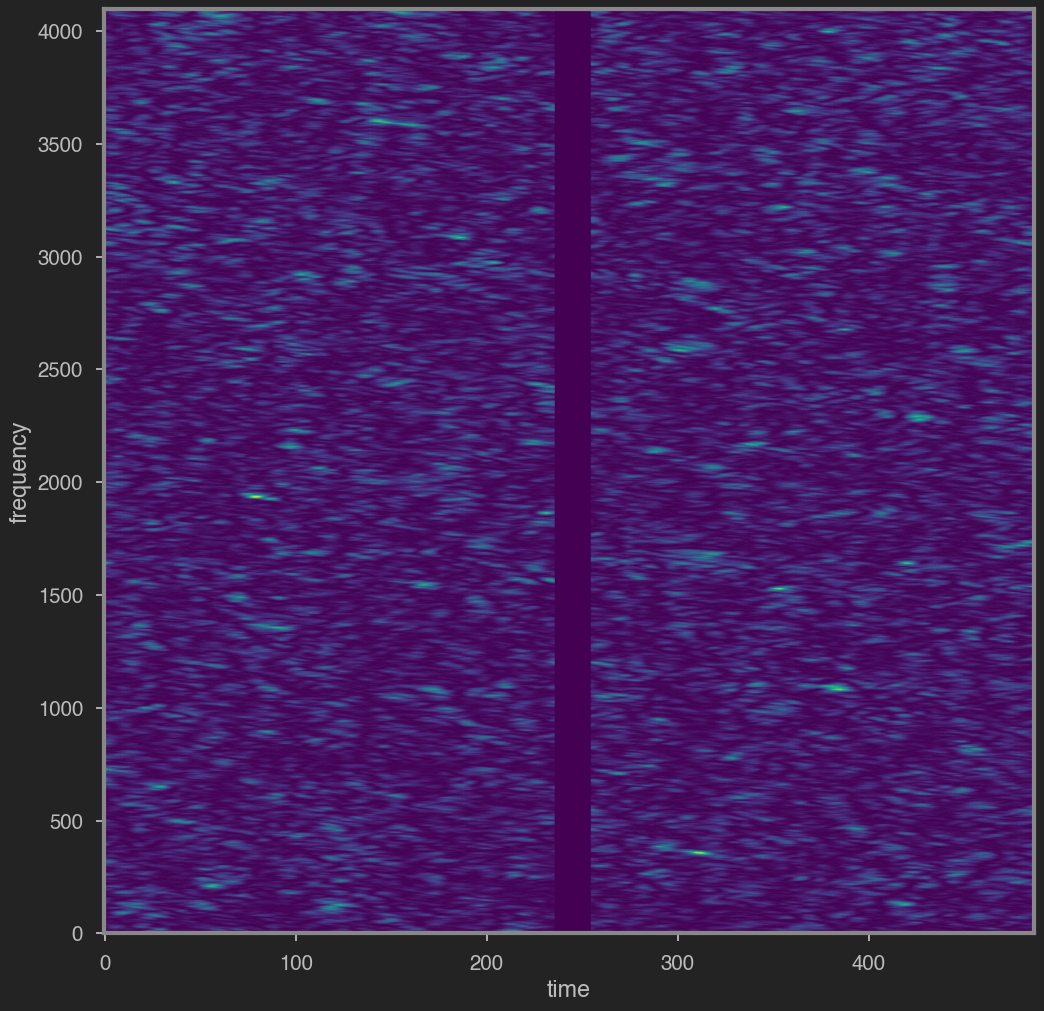

In [2]:
data = get_data("data/observed/J1939+2134.fits")

plt.imshow(data.T)
_ = plt.xlabel("time")
_ = plt.ylabel("frequency")

### Generate mask for the "impulsive RFI", i.e., data gaps:

In [3]:
from auxiliary import generate_narrowband_RFI_mask

mask = generate_narrowband_RFI_mask(data, 1, 5, window = 51)
data_clean = data * mask
print(f"subints zapped {(np.prod(mask.shape)-np.count_nonzero(mask))/mask.shape[1]} ({(np.prod(mask.shape)-np.count_nonzero(mask))/np.prod(mask.shape)*100:.1f} %)")

subints zapped 19.0 (3.9 %)


## H-FISTA
### Generate initial values

In [4]:
# initial guess with all power in one wave at the origin
N, M = data.shape
h_init = np.zeros((N, M)) + np.zeros((N, M)) * 1.0j

init_value = np.sqrt(np.mean(data * mask)) * N * M + 0.0j
init_coords = [0, 0]
h_init[init_coords[0], init_coords[1]] = init_value

# H-FISTA configuration
lambda_scale = 1.15
desired_number_of_components_after_first_step = 60
fix_phase_value = 0.0
fix_phase_coords = init_coords

# FISTA configuration
FISTA_niter = 80
delay_for_inf = -4
backtrack = True
verbose = False

### Initialise I/O dictionary

In [5]:
# pre-populate the rest of the input output dictionary
io = initialize_io_dict()

# setup the initial guess as a step so that we can use the exact same loop for all runs below
step = 0

io["niters"][step] = 0 

# mask = np.ones_like(data) # in this particular case, we already have a mask
io["masks"][step] = mask
resid = Residual(data, h_init, None, mask)
io["lambdas"][step] = get_initial_lambda(desired_number_of_components_after_first_step, delay_for_inf, resid) * lambda_scale
io["models"][step] = h_init
io["demerits"][step] = -1
io["predictions"][step] = resid.prediction
io["residuals"][step] = resid.residual

In [6]:
chosen_step = -1

approved = np.transpose(np.nonzero(h_init))

for step in range(1, 101):
    io["niters"][step] = FISTA_niter
    ref_lambda = io["lambdas"][step-1]/lambda_scale

    lambda_loop_config = {
        "backtrack": backtrack,
        "fix_phase_value": fix_phase_value,
        "fix_phase_coords": init_coords,
        "ref_lambda": ref_lambda, 
        "verbose": verbose,
        "delay_for_inf": delay_for_inf,
        "zero_penalty_coords": approved,
    }

    print()
    print(f"### λ iteration {step} with λ={ref_lambda} and scaling {lambda_scale} ###")
    print() 

    approved = take_lambda_step(data, io, step, **lambda_loop_config)
    io["lambdas"][step] = ref_lambda
    
    if step > 1:
        if check_stopping(io, step):
            chosen_step = step - 1
            print(f"Stopping criterion triggered in step {step}")
            break


### λ iteration 1 with λ=0.022267730898319165 and scaling 1.15 ###

2022-10-27 13:08:50,943 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 1 components (approved: 1 and fixed support 0)
2022-10-27 13:08:55,937 - H-FISTA.fista - INFO - backtrack_B3 found 2.46e-06 after 6 iterations. Model has 60 el.
2022-10-27 13:08:56,128 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 60 non-zero elements with demerit 9.72e+05
2022-10-27 13:09:42,401 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 63 non-zero elements with demerit 9.63e+05
2022-10-27 13:10:08,847 - H-FISTA.fista - INFO - Arrived at model with 63 components/ 9.63e+05 after 80 iterations
2022-10-27 13:10:09,007 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 63 components (approved: 0 and fixed support 63)
2022-10-27 13:10:09,008 - H-FISTA.fista - INFO - Fixing support
2022-10-27 13:10:10,501 - H-FISTA.fista - INFO - backtrack_B3 found 1.53e-06 after 1 iterations. Model has 63 el.
2022-10-27 


### λ iteration 6 with λ=0.01107099775052718 and scaling 1.15 ###

2022-10-27 13:21:51,469 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 710 components (approved: 710 and fixed support 0)
2022-10-27 13:21:52,908 - H-FISTA.fista - INFO - backtrack_B3 found 1.51e-06 after 1 iterations. Model has 1002 el.
2022-10-27 13:21:53,091 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 1002 non-zero elements with demerit 6.37e+05
2022-10-27 13:22:00,027 - H-FISTA.fista - INFO - backtrack_B3 found 1.66e-06 after 1 iterations. Model has 987 el.
2022-10-27 13:22:06,207 - H-FISTA.fista - INFO - backtrack_B3 found 1.83e-06 after 1 iterations. Model has 986 el.
2022-10-27 13:22:40,008 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 986 non-zero elements with demerit 6.31e+05
2022-10-27 13:23:06,310 - H-FISTA.fista - INFO - Arrived at model with 986 components/ 6.31e+05 after 80 iterations
2022-10-27 13:23:06,466 - H-FISTA.fista - INFO - Running FISTA from an initial guess with

2022-10-27 13:33:27,556 - H-FISTA.fista - INFO - backtrack_B3 found 2.43e-06 after 6 iterations. Model has 2610 el.
2022-10-27 13:34:06,768 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 2610 non-zero elements with demerit 3.64e+05
2022-10-27 13:34:32,280 - H-FISTA.fista - INFO - Arrived at model with 2610 components/ 3.64e+05 after 80 iterations
2022-10-27 13:34:32,427 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 2609 components (approved: 0 and fixed support 2609)
2022-10-27 13:34:32,428 - H-FISTA.fista - INFO - Fixing support
2022-10-27 13:34:36,406 - H-FISTA.fista - INFO - backtrack_B3 found 2.21e-06 after 5 iterations. Model has 2609 el.
2022-10-27 13:34:36,587 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 2609 non-zero elements with demerit 3.64e+05
2022-10-27 13:35:19,313 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 2609 non-zero elements with demerit 3.64e+05
2022-10-27 13:35:43,896 - H-FISTA.fista - INFO - Arrived at model with 2609 compon

2022-10-27 13:45:01,566 - H-FISTA.fista - INFO - backtrack_B3 found 2.94e-06 after 7 iterations. Model has 5821 el.
2022-10-27 13:45:43,907 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 5787 non-zero elements with demerit 2.39e+05
2022-10-27 13:46:10,508 - H-FISTA.fista - INFO - Arrived at model with 5786 components/ 2.39e+05 after 80 iterations
2022-10-27 13:46:10,694 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 5786 components (approved: 0 and fixed support 5786)
2022-10-27 13:46:10,695 - H-FISTA.fista - INFO - Fixing support
2022-10-27 13:46:12,155 - H-FISTA.fista - INFO - backtrack_B3 found 1.51e-06 after 1 iterations. Model has 5786 el.
2022-10-27 13:46:12,347 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 5786 non-zero elements with demerit 2.27e+05
2022-10-27 13:46:24,449 - H-FISTA.fista - INFO - backtrack_B3 found 4.31e-06 after 11 iterations. Model has 5786 el.
2022-10-27 13:47:07,461 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 5786 non-z

2022-10-27 13:57:31,754 - H-FISTA.fista - INFO - backtrack_B3 found 2.68e-06 after 7 iterations. Model has 9433 el.
2022-10-27 13:57:31,947 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 9433 non-zero elements with demerit 1.51e+05
2022-10-27 13:57:41,883 - H-FISTA.fista - INFO - backtrack_B3 found 3.92e-06 after 4 iterations. Model has 9433 el.
2022-10-27 13:58:20,283 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 9433 non-zero elements with demerit 1.51e+05
2022-10-27 13:58:46,815 - H-FISTA.fista - INFO - Arrived at model with 9433 components/ 1.51e+05 after 80 iterations
2022-10-27 13:58:46,869 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 2 with threshold 607.5434611026959
2022-10-27 13:58:46,874 - H-FISTA.lambda_loop - INFO - RFI mask now includes 4.84 per cent of data

### λ iteration 18 with λ=0.0020692486392740257 and scaling 1.15 ###

2022-10-27 13:58:47,076 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 9433 components (a

2022-10-27 14:11:49,691 - H-FISTA.fista - INFO - Arrived at model with 12810 components/ 1.21e+05 after 80 iterations
2022-10-27 14:11:49,753 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 3 with threshold 345.2183097850133
2022-10-27 14:11:49,758 - H-FISTA.lambda_loop - INFO - RFI mask now includes 4.84 per cent of data

### λ iteration 20 with λ=0.001564649254649547 and scaling 1.15 ###

2022-10-27 14:11:49,961 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 12810 components (approved: 12810 and fixed support 0)
2022-10-27 14:11:51,501 - H-FISTA.fista - INFO - backtrack_B3 found 1.51e-06 after 1 iterations. Model has 15196 el.
2022-10-27 14:11:51,698 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 15196 non-zero elements with demerit 1.2e+05
2022-10-27 14:12:04,172 - H-FISTA.fista - INFO - backtrack_B3 found 5.21e-06 after 13 iterations. Model has 15079 el.
2022-10-27 14:12:48,175 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 14956

2022-10-27 14:23:40,776 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 24041 non-zero elements with demerit 8.68e+04
2022-10-27 14:23:43,140 - H-FISTA.fista - INFO - backtrack_B3 found 1.66e-06 after 1 iterations. Model has 23919 el.
2022-10-27 14:23:55,044 - H-FISTA.fista - INFO - backtrack_B3 found 6.94e-06 after 15 iterations. Model has 23920 el.
2022-10-27 14:24:38,478 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 23747 non-zero elements with demerit 8.57e+04
2022-10-27 14:25:05,039 - H-FISTA.fista - INFO - Arrived at model with 23738 components/ 8.57e+04 after 80 iterations
2022-10-27 14:25:05,207 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 23738 components (approved: 0 and fixed support 23738)
2022-10-27 14:25:05,208 - H-FISTA.fista - INFO - Fixing support
2022-10-27 14:25:06,677 - H-FISTA.fista - INFO - backtrack_B3 found 1.51e-06 after 1 iterations. Model has 23738 el.
2022-10-27 14:25:06,862 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 237

2022-10-27 14:36:05,559 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 38888 non-zero elements with demerit 5.77e+04
2022-10-27 14:36:32,198 - H-FISTA.fista - INFO - Arrived at model with 38888 components/ 5.77e+04 after 80 iterations
2022-10-27 14:36:32,314 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 73.27923615940878
2022-10-27 14:36:32,319 - H-FISTA.lambda_loop - INFO - RFI mask now includes 4.86 per cent of data

### λ iteration 27 with λ=0.0005882096093108239 and scaling 1.15 ###

2022-10-27 14:36:32,562 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 38888 components (approved: 38888 and fixed support 0)
2022-10-27 14:36:34,048 - H-FISTA.fista - INFO - backtrack_B3 found 1.51e-06 after 1 iterations. Model has 47084 el.
2022-10-27 14:36:34,246 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 47084 non-zero elements with demerit 5.73e+04
2022-10-27 14:36:37,400 - H-FISTA.fista - INFO - backtrack_B3 found 1.83e-0

2022-10-27 14:48:34,697 - H-FISTA.fista - INFO - Fixing support
2022-10-27 14:48:36,275 - H-FISTA.fista - INFO - backtrack_B3 found 1.51e-06 after 1 iterations. Model has 66641 el.
2022-10-27 14:48:36,513 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 66641 non-zero elements with demerit 4.34e+04
2022-10-27 14:48:39,325 - H-FISTA.fista - INFO - backtrack_B3 found 1.66e-06 after 1 iterations. Model has 66641 el.
2022-10-27 14:48:54,874 - H-FISTA.fista - INFO - backtrack_B3 found 9.23e-06 after 18 iterations. Model has 66641 el.
2022-10-27 14:49:39,692 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 66641 non-zero elements with demerit 4.17e+04
2022-10-27 14:50:07,162 - H-FISTA.fista - INFO - Arrived at model with 66641 components/ 4.17e+04 after 80 iterations
2022-10-27 14:50:07,489 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 66640 components (approved: 0 and fixed support 66640)
2022-10-27 14:50:07,490 - H-FISTA.fista - INFO - Fixing support
2022-10-27 14:

In [7]:
print(f"chosen step: {chosen_step} sparse wavefield components: {np.count_nonzero(io['models'][chosen_step])}")

chosen step: 28 sparse wavefield components: 55225


### Inspect dynamic field progression

#### Plot the magnitude and phase of the dynamic field H

We note that that the magnitude of H is the square root of the dynamic spectrum

We plot the dynamic field for the first three λ iterations, and the chosen step

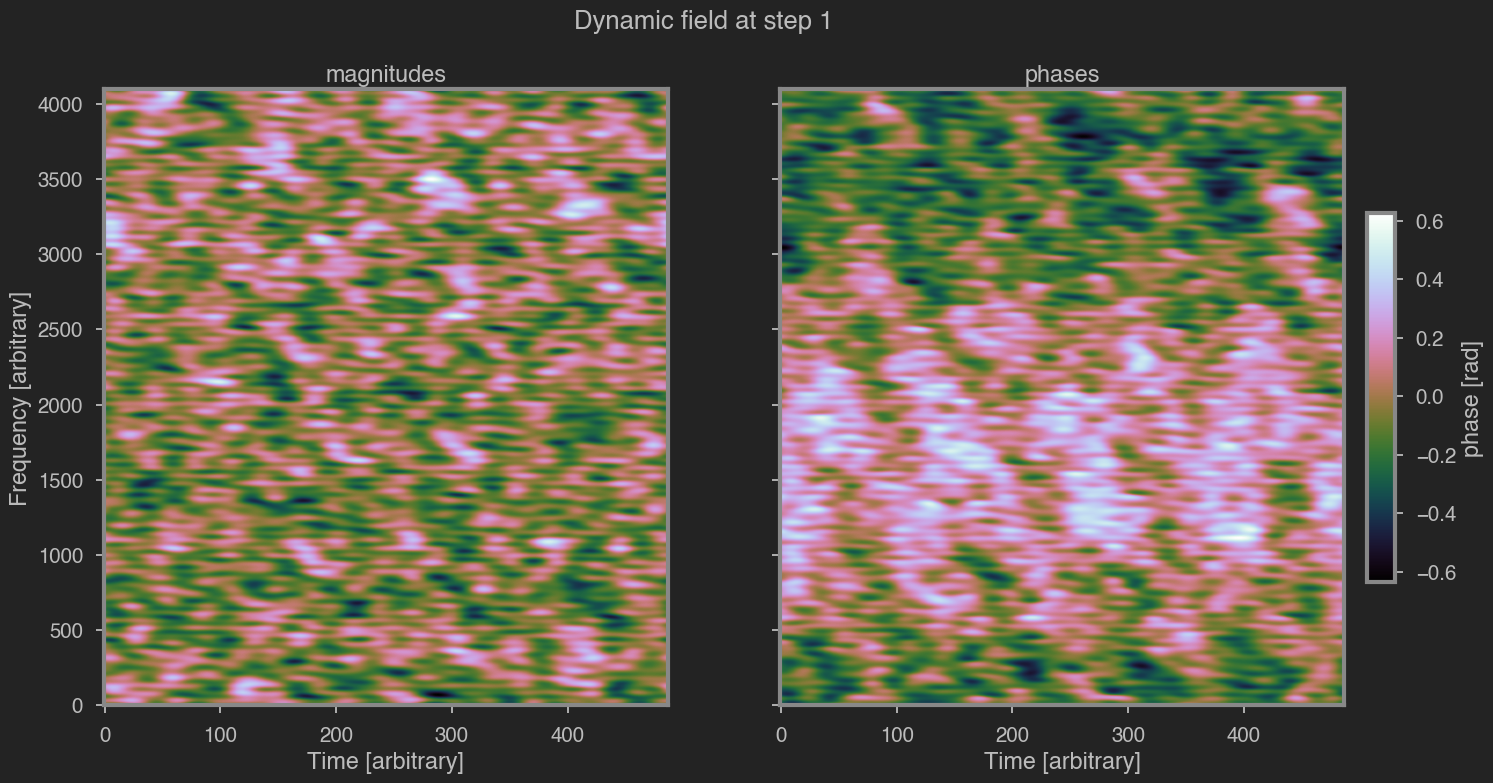

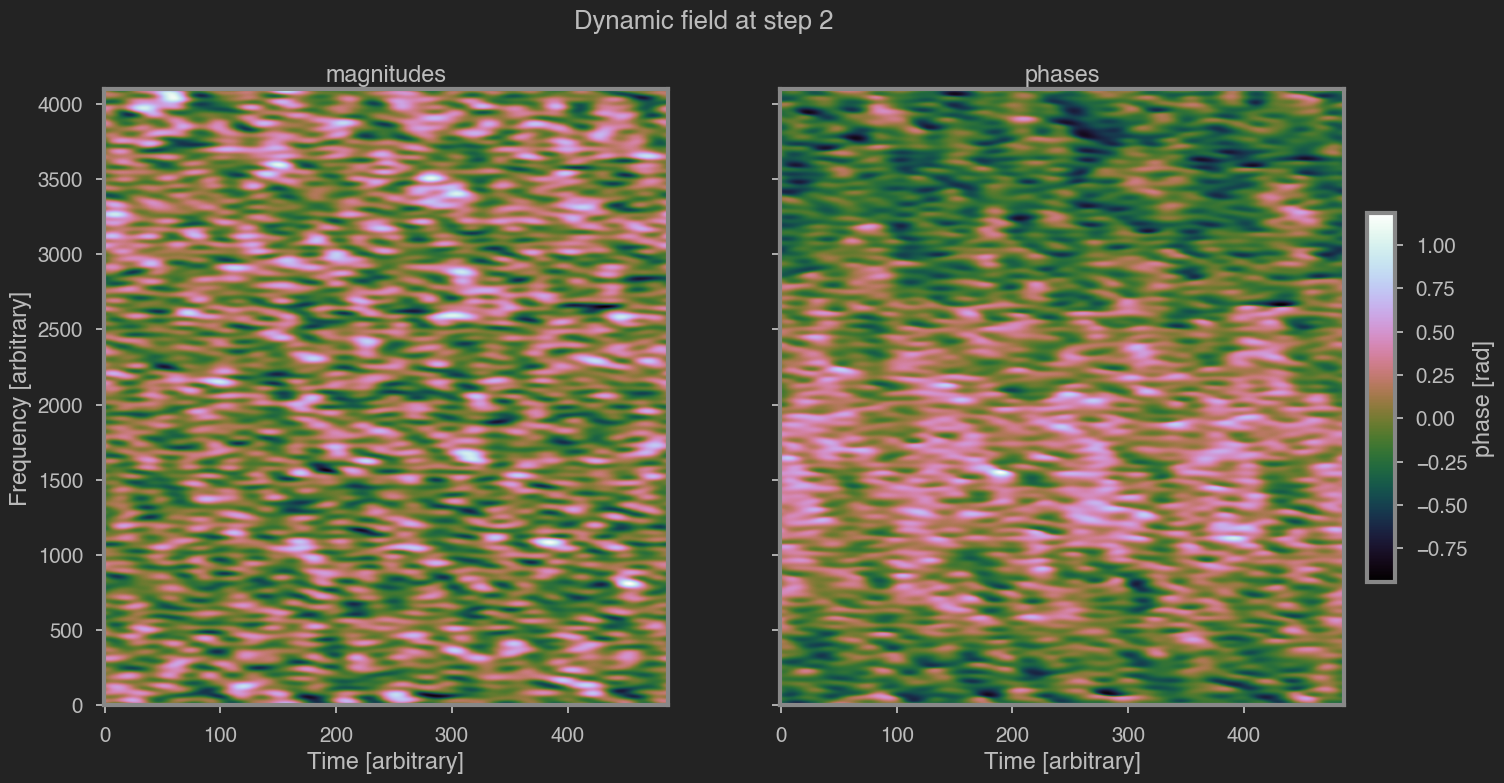

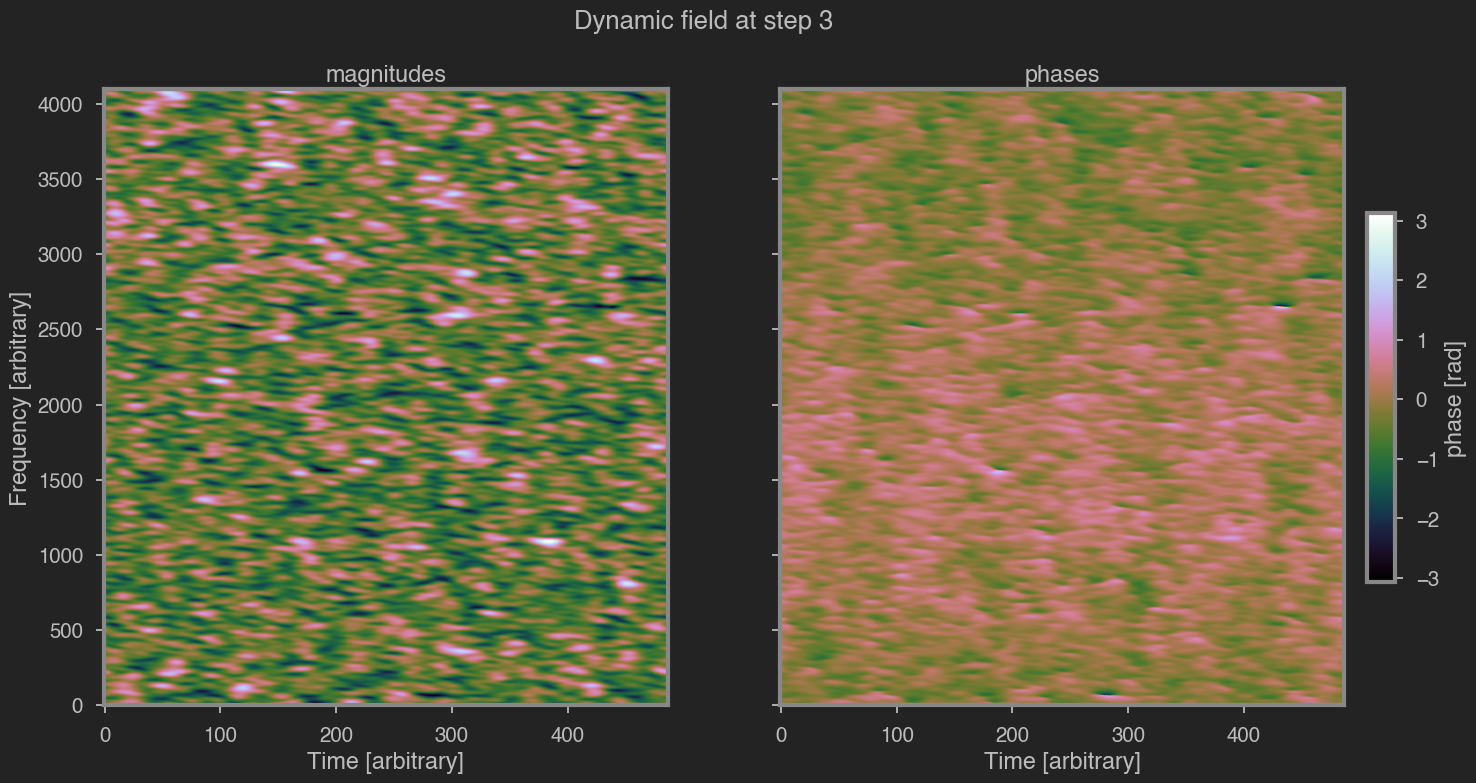

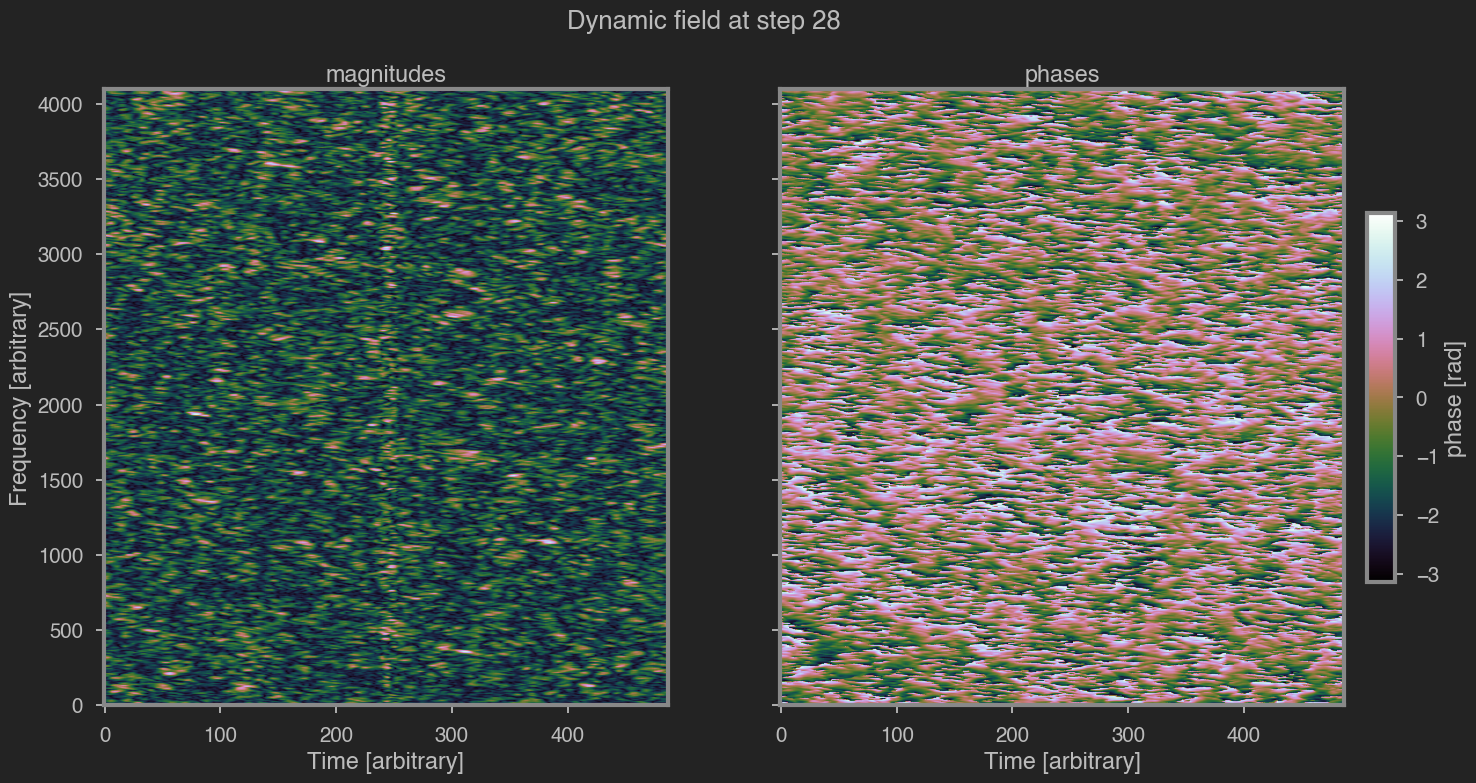

In [8]:
inspect_steps = [1, 2, 3]

if chosen_step > 0:
    inspect_steps.append(chosen_step)
else:
    inspect_steps.append(np.max(list(io["models"].keys())))

for _step in inspect_steps:
    get_dynamic_field_plot(data, io, _step)

### Diagnostic plot

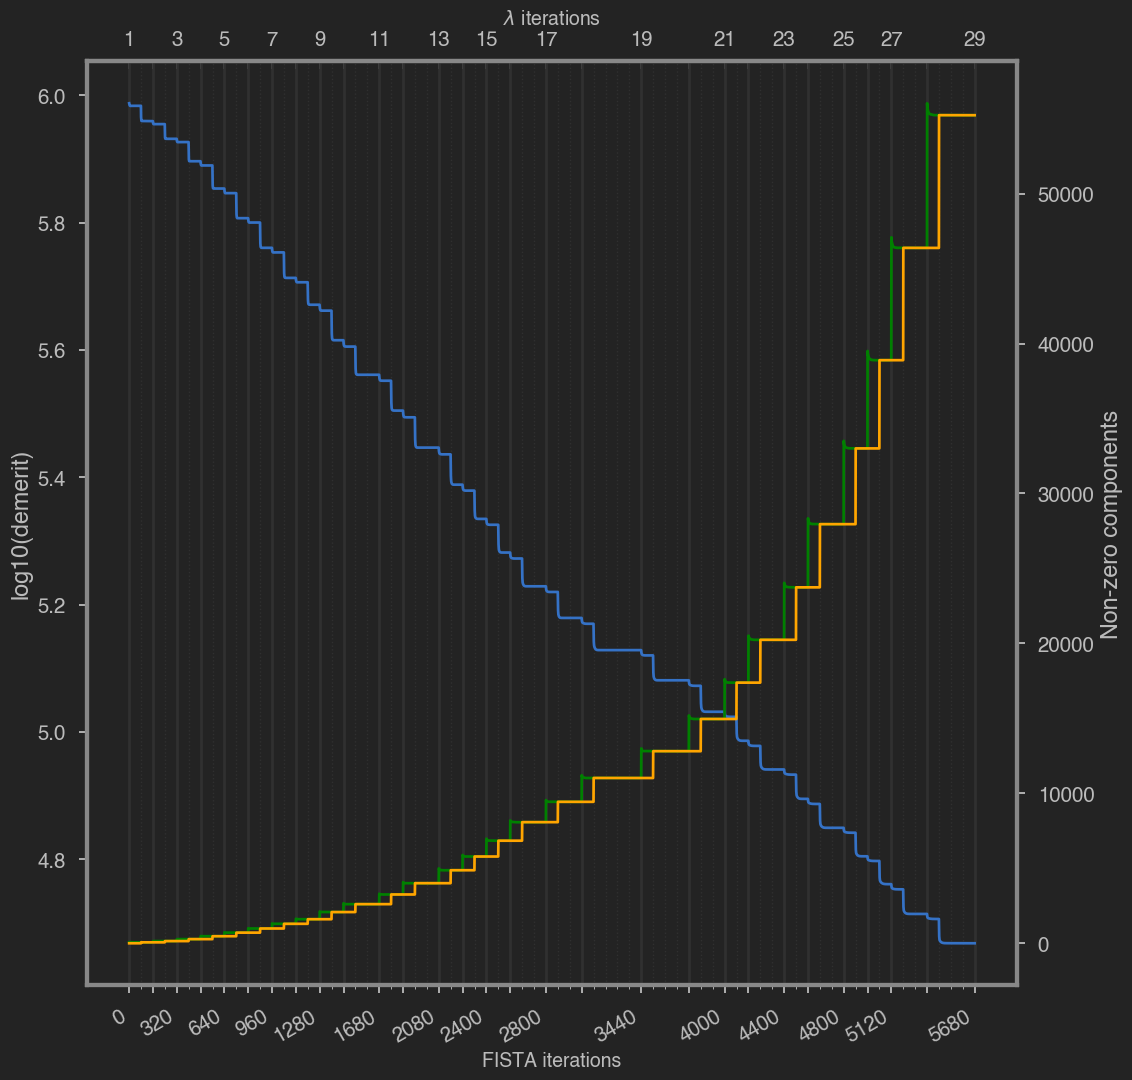

In [9]:
diagnostic_args = {}
if chosen_step > 0:
    diagnostic_args["max_step"] = chosen_step
get_diag_plot(io, **diagnostic_args)

#### Refine with unconstrained FISTA

In [10]:
from densify import get_dense_solution

dense_wavefield = get_dense_solution(io["models"][chosen_step], data, io["masks"][chosen_step])

2022-10-27 14:53:10,564 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 55225 components (approved: 0 and fixed support 0)
2022-10-27 14:53:24,402 - H-FISTA.fista - INFO - backtrack_B3 found 6.3e-06 after 16 iterations. Model has 1994752 el.
2022-10-27 14:53:24,603 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 1994752 non-zero elements with demerit 2.77e+04
2022-10-27 14:53:38,960 - H-FISTA.fista - INFO - backtrack_B3 found 2.39e-05 after 14 iterations. Model has 1994752 el.
2022-10-27 14:54:26,696 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 1994752 non-zero elements with demerit 57.7
2022-10-27 14:55:14,764 - H-FISTA.fista - INFO - in iteration 100, x_np1 has 1994752 non-zero elements with demerit 4.39
2022-10-27 14:56:03,294 - H-FISTA.fista - INFO - in iteration 150, x_np1 has 1994752 non-zero elements with demerit 0.886
2022-10-27 14:56:50,654 - H-FISTA.fista - INFO - in iteration 200, x_np1 has 1994752 non-zero elements with demerit 0.277
2022-10-27 1

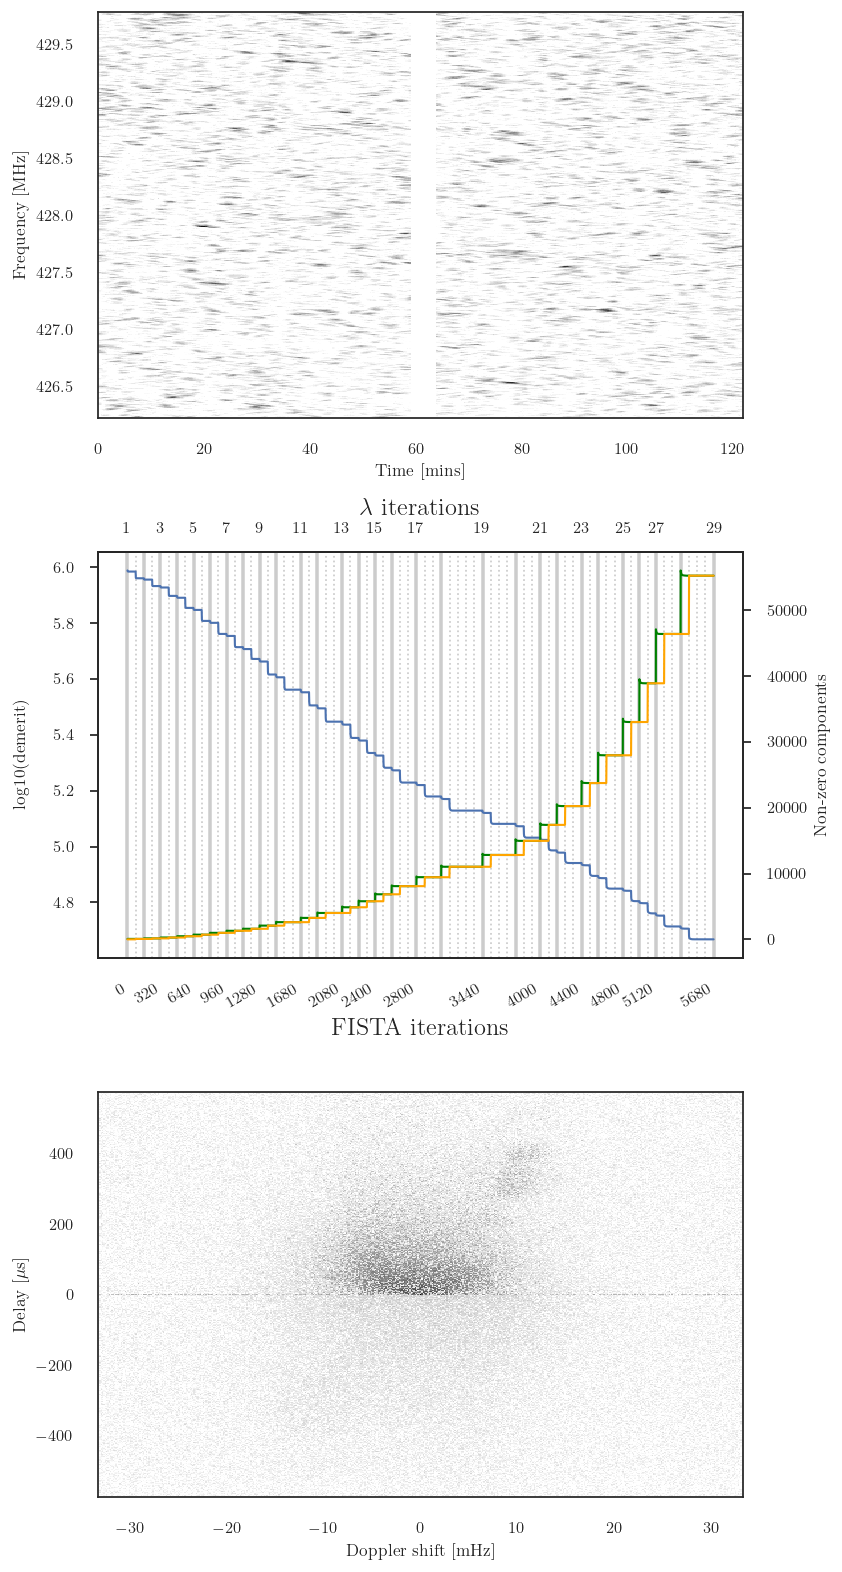

In [12]:
dense_resid = Residual(data, dense_wavefield, None, io["masks"][chosen_step])
fig, axs = get_paper_figure(
    io,
    data,
    chosen_step=chosen_step,
    resid=dense_resid,
    outfn="fig_J1939.eps",
    cfreq=428,
    bw=32 / 9,
    subint_time=15,
    flip_doppler=True,
    vmin=0.632,
    vmin_data=0.10,
)

In [13]:
import pickle

with open("output/J1937+2134_io.pkl", "wb") as fh:
    pickle.dump(io, fh)

with open("output/J1939+2134_dense.pkl", "wb") as fh:
    pickle.dump(dense_resid, fh)